# Fast Style Transfer with FastEstimator

In this notebook we will demonstrate how to do a neural image style transfer with perceptual loss as described in [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf).
Typical neural style transfer involves two images: an image containing semantics that you want to preserve, and another image serving as a reference style. The first image is often referred as the *content image* and the other image as the *style image*.
In [this paper](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf) training images from the COCO2014 dataset are used to learn style transfer from any content image.

In [1]:
import tempfile
import cv2
import tensorflow as tf
import numpy as np

import fastestimator as fe
from fastestimator.backend import reduce_mean
from fastestimator.op.numpyop import LambdaOp
from fastestimator.op.numpyop.multivariate import Resize
from fastestimator.op.numpyop.univariate import Normalize, ReadImage
from fastestimator.trace.io import ModelSaver
from fastestimator.util import ImageDisplay, GridDisplay

from matplotlib import pyplot as plt

In [2]:
#Parameters
batch_size = 4
epochs = 2
train_steps_per_epoch = None
log_steps = 2000
style_weight=5.0
content_weight=1.0
tv_weight=1e-4
save_dir = tempfile.mkdtemp()
style_img_path = 'Vassily_Kandinsky,_1913_-_Composition_7.jpg'
test_img_path = 'panda.jpeg'
data_dir = None

In this notebook we will use *Vassily Kandinsky's Composition 7* as a style image.
We will also resize the style image to $256 \times 256$ to make the dimension consistent with that of COCO images.

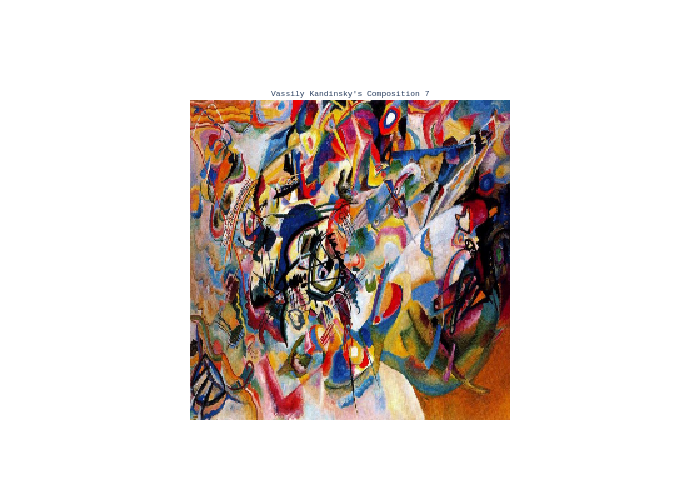

In [3]:
style_img = cv2.imread(style_img_path)
assert style_img is not None, "cannot load the style image, please go to the folder with style image"
style_img = cv2.resize(style_img, (256, 256))
style_img = (style_img.astype(np.float32) - 127.5) / 127.5
style_img_disp = cv2.cvtColor((style_img + 1) * 0.5, cv2.COLOR_BGR2RGB)

ImageDisplay(image=style_img_disp, title='Vassily Kandinsky\'s Composition 7').show()

## Building Components

### Downloading the data

First, we will download training images from the COCO2014 dataset via our dataset API. Downloading the images will take a while.

In [4]:
from fastestimator.dataset.data import mscoco
train_data, _ = mscoco.load_data(root_dir=data_dir, load_bboxes=False, load_masks=False, load_captions=False)

### Step 1: Create `Pipeline`

In [5]:
pipeline = fe.Pipeline(
    train_data=train_data,
    batch_size=batch_size,
    ops=[
        ReadImage(inputs="image", outputs="image"),
        Normalize(inputs="image", outputs="image", mean=1.0, std=1.0, max_pixel_value=127.5),
        Resize(height=256, width=256, image_in="image", image_out="image"),
        LambdaOp(fn=lambda: style_img, outputs="style_image"),
    ])

We can visualize sample images from our `Pipeline` using the 'get_results' method:

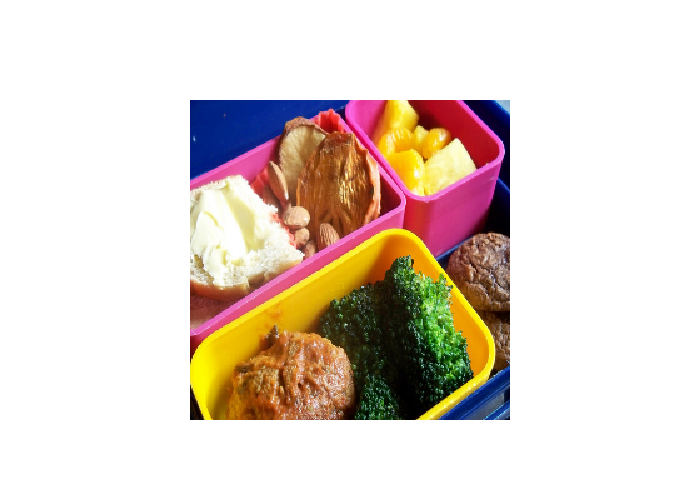

In [6]:
sample_batch = pipeline.get_results()
ImageDisplay(image=sample_batch["image"][0]).show()

### Step 2: Create `Network`

The architecture of our model is a modified ResNet:

In [7]:
from typing import Dict, List, Tuple, Union

import tensorflow as tf

from fastestimator.layers.tensorflow import InstanceNormalization, ReflectionPadding2D


def _residual_block(x0, num_filter, kernel_size=(3, 3), strides=(1, 1)):
    initializer = tf.random_normal_initializer(0., 0.02)
    x0_cropped = tf.keras.layers.Cropping2D(cropping=2)(x0)

    x = tf.keras.layers.Conv2D(filters=num_filter,
                               kernel_size=kernel_size,
                               strides=strides,
                               kernel_initializer=initializer)(x0)
    x = InstanceNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(filters=num_filter,
                               kernel_size=kernel_size,
                               strides=strides,
                               kernel_initializer=initializer)(x)

    x = InstanceNormalization()(x)
    x = tf.keras.layers.Add()([x, x0_cropped])
    return x


def _conv_block(x0, num_filter, kernel_size=(9, 9), strides=(1, 1), padding="same", apply_relu=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    x = tf.keras.layers.Conv2D(filters=num_filter,
                               kernel_size=kernel_size,
                               strides=strides,
                               padding=padding,
                               kernel_initializer=initializer)(x0)

    x = InstanceNormalization()(x)
    if apply_relu:
        x = tf.keras.layers.ReLU()(x)
    return x


def _upsample(x0, num_filter, kernel_size=(3, 3), strides=(2, 2), padding="same"):
    initializer = tf.random_normal_initializer(0., 0.02)
    x = tf.keras.layers.Conv2DTranspose(filters=num_filter,
                                        kernel_size=kernel_size,
                                        strides=strides,
                                        padding=padding,
                                        kernel_initializer=initializer)(x0)

    x = InstanceNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x


def _downsample(x0, num_filter, kernel_size=(3, 3), strides=(2, 2), padding="same"):
    initializer = tf.random_normal_initializer(0., 0.02)
    x = tf.keras.layers.Conv2D(filters=num_filter,
                               kernel_size=kernel_size,
                               strides=strides,
                               padding=padding,
                               kernel_initializer=initializer)(x0)

    x = InstanceNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x


def StyleTransferNet(input_shape=(256, 256, 3), num_resblock=5):
    """Creates the Style Transfer Network.
    """
    x0 = tf.keras.layers.Input(shape=input_shape)
    x = ReflectionPadding2D(padding=(40, 40))(x0)
    x = _conv_block(x, num_filter=32)
    x = _downsample(x, num_filter=64)
    x = _downsample(x, num_filter=128)

    for _ in range(num_resblock):
        x = _residual_block(x, num_filter=128)

    x = _upsample(x, num_filter=64)
    x = _upsample(x, num_filter=32)
    x = _conv_block(x, num_filter=3, apply_relu=False)
    x = tf.keras.layers.Activation("tanh")(x)
    return tf.keras.Model(inputs=x0, outputs=x)


def LossNet(input_shape=(256, 256, 3),
            style_layers=["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3"],
            content_layers=["block3_conv3"]):
    """Creates the network to compute the style loss.
    This network outputs a dictionary with outputs values for style and content, based on a list of layers from VGG16
    for each.
    """
    x0 = tf.keras.layers.Input(shape=input_shape)
    mdl = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=x0)
    # Compute style loss
    style_output = [mdl.get_layer(name).output for name in style_layers]
    content_output = [mdl.get_layer(name).output for name in content_layers]
    output = {"style": style_output, "content": content_output}
    return tf.keras.Model(inputs=x0, outputs=output)

In [8]:
model = fe.build(model_fn=StyleTransferNet, 
                 model_name="style_transfer_net",
                 optimizer_fn=lambda: tf.optimizers.Adam(1e-3))

2022-05-19 16:39:16.502668: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-19 16:39:17.136446: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38420 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:87:00.0, compute capability: 8.0


### Defining Loss

The perceptual loss described in the [paper](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf) is computed based on intermediate layers of VGG16 pretrained on ImageNet; specifically, `relu1_2`, `relu2_2`, `relu3_3`, and `relu4_3` of VGG16 are used.

The *style* loss term is computed as the squared l2 norm of the difference in Gram Matrix of these feature maps between an input image and the reference style image.

The *content* loss is simply the l2 norm of the difference in `relu3_3` of the input image and the reference style image. In addition, the method also uses total variation loss to enforce spatial smoothness in the output image.

The final loss is a weighted sum of the style loss term, the content loss term (feature reconstruction term in the [paper](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf)), and the total variation term.

We first define a custom `TensorOp` that outputs intermediate layers of VGG16. Given these intermediate layers returned by the loss network as a dictionary, we define a custom `StyleContentLoss` class that encapsulates all the logic of the loss calculation.

In [9]:
from fastestimator.op.tensorop import TensorOp

class ExtractVGGFeatures(TensorOp):
    def __init__(self, inputs, outputs, mode=None):
        super().__init__(inputs, outputs, mode)
        self.vgg = LossNet()

    def forward(self, data, state):
        return self.vgg(data)


class StyleContentLoss(TensorOp):
    def __init__(self, style_weight, content_weight, tv_weight, inputs, outputs=None, mode=None, average_loss=True):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.style_weight = style_weight
        self.content_weight = content_weight
        self.tv_weight = tv_weight
        self.average_loss = average_loss

    def calculate_style_recon_loss(self, y_true, y_pred):
        y_true_gram = self.calculate_gram_matrix(y_true)
        y_pred_gram = self.calculate_gram_matrix(y_pred)
        y_diff_gram = y_pred_gram - y_true_gram
        y_norm = tf.math.sqrt(tf.reduce_sum(tf.math.square(y_diff_gram), axis=(1, 2)))
        return y_norm

    def calculate_feature_recon_loss(self, y_true, y_pred):
        y_diff = y_pred - y_true
        num_elts = tf.cast(tf.reduce_prod(y_diff.shape[1:]), tf.float32)
        y_diff_norm = tf.reduce_sum(tf.square(y_diff), axis=(1, 2, 3)) / num_elts
        return y_diff_norm

    def calculate_gram_matrix(self, x):
        x = tf.cast(x, tf.float32)
        num_elts = tf.cast(x.shape[1] * x.shape[2] * x.shape[3], tf.float32)
        gram_matrix = tf.einsum('bijc,bijd->bcd', x, x)
        gram_matrix /= num_elts
        return gram_matrix

    def calculate_total_variation(self, y_pred):
        return tf.image.total_variation(y_pred)

    def forward(self, data, state):
        y_pred, y_style, y_content, image_out = data

        style_loss = [self.calculate_style_recon_loss(a, b) for a, b in zip(y_style['style'], y_pred['style'])]
        style_loss = tf.add_n(style_loss)
        style_loss *= self.style_weight

        content_loss = [
            self.calculate_feature_recon_loss(a, b) for a, b in zip(y_content['content'], y_pred['content'])
        ]
        content_loss = tf.add_n(content_loss)
        content_loss *= self.content_weight

        total_variation_reg = self.calculate_total_variation(image_out)
        total_variation_reg *= self.tv_weight
        loss = style_loss + content_loss + total_variation_reg

        if self.average_loss:
            loss = reduce_mean(loss)

        return loss

We now define the `Network` object:

In [10]:
from fastestimator.op.tensorop.model import ModelOp, UpdateOp

network = fe.Network(ops=[
    ModelOp(inputs="image", model=model, outputs="image_out"),
    ExtractVGGFeatures(inputs="style_image", outputs="y_style"),
    ExtractVGGFeatures(inputs="image", outputs="y_content"),
    ExtractVGGFeatures(inputs="image_out", outputs="y_pred"),
    StyleContentLoss(style_weight=style_weight,
                     content_weight=content_weight,
                     tv_weight=tv_weight,
                     inputs=('y_pred', 'y_style', 'y_content', 'image_out'),
                     outputs='loss'),
    UpdateOp(model=model, loss_name="loss")
])

2022-05-19 16:39:18.707513: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


### Step 3: Estimator

We can now define the `Estimator`. We will use `Trace` to save intermediate models:

In [11]:
estimator = fe.Estimator(network=network,
                         pipeline=pipeline,
                         traces=ModelSaver(model=model, save_dir=save_dir, frequency=1),
                         epochs=epochs,
                         train_steps_per_epoch=train_steps_per_epoch,
                         log_steps=log_steps)

## Training

In [12]:
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Warn: the key 'image_id' is being pruned since it is unused outside of the Pipeline. To prevent this, you can declare the key as an input of a Trace or TensorOp.


2022-05-19 16:39:27.370274: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


FastEstimator-Start: step: 1; logging_interval: 2000; num_device: 1;
FastEstimator-Train: step: 1; loss: 678.7794;
FastEstimator-Train: step: 2000; loss: 180.73315; steps/sec: 18.63;
FastEstimator-Train: step: 4000; loss: 172.81424; steps/sec: 18.74;
FastEstimator-Train: step: 6000; loss: 158.67215; steps/sec: 18.12;
FastEstimator-Train: step: 8000; loss: 139.94647; steps/sec: 18.73;
FastEstimator-Train: step: 10000; loss: 158.4191; steps/sec: 18.24;
FastEstimator-Train: step: 12000; loss: 162.1073; steps/sec: 18.7;
FastEstimator-Train: step: 14000; loss: 162.72255; steps/sec: 18.74;
FastEstimator-Train: step: 16000; loss: 151.46005; steps/sec: 18.48;
FastEstimator-Train: step: 18000; loss: 158.79842; steps/sec: 18.28;
FastEstimator-Train: step: 20000; loss: 152.6825; steps/sec: 18.73;
FastEstimator-Train: step: 22000; loss: 158.96213; steps/sec: 18.18;
FastEstimator-Train: step: 24000; loss: 156.94514; steps/sec: 18.53;
FastEstimator-Train: step: 26000; loss: 156.16516; steps/sec: 18.

## Inferencing

Once the training is finished, we will apply the model to perform style transfer on arbitrary images. Here we use a photo of a panda.

In [13]:
data = {"image":test_img_path}
result = pipeline.transform(data, mode="infer")
test_img = np.squeeze(result["image"])

In [14]:
network = fe.Network(ops=[
    ModelOp(inputs='image', model=model, outputs="image_out")
])

predictions = network.transform(result, mode="infer")
output_img = np.squeeze(predictions["image_out"])

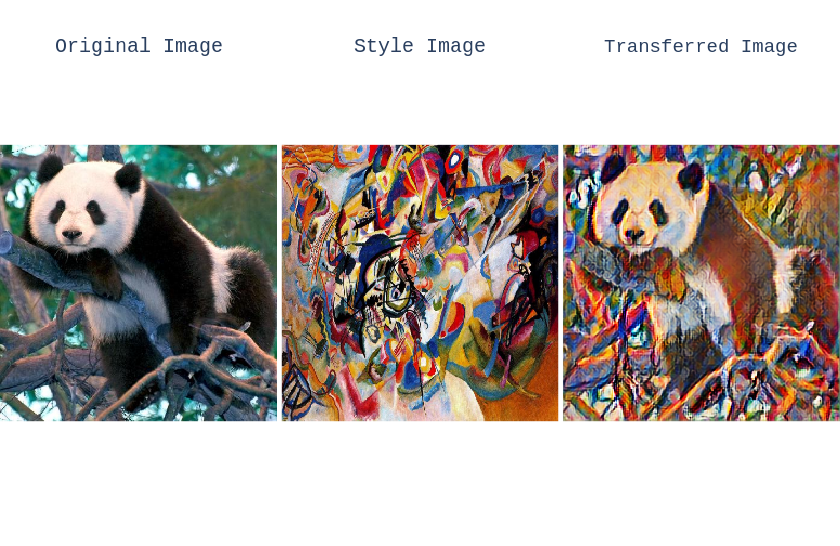

In [15]:
output_img_disp = cv2.cvtColor((output_img + 1) * 0.5, cv2.COLOR_BGR2RGB)
test_img_disp = cv2.cvtColor((test_img + 1) * 0.5, cv2.COLOR_BGR2RGB)

GridDisplay([ImageDisplay(image=test_img_disp, title='Original Image'), 
             ImageDisplay(image=style_img_disp, title='Style Image'),
             ImageDisplay(image=output_img_disp, title='Transferred Image')
            ]).show()